# Serialise Detections to a CSV File

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/detections-to-jsonsink.ipynb)

This cookbook introduce [sv.CSVSink](https://supervision.roboflow.com/latest/detection/tools/save_detections/#supervision.detection.tools.csv_sink.CSVSink) tool designed to write captured object detection data to file from video streams/file

Click the `Open in Colab` button to run the cookbook on Google Colab.

In [ ]:
!pip install -q inference requests tqdm supervision==0.21.0

In [3]:
import supervision as sv
from supervision.assets import download_assets, VideoAssets
from inference import InferencePipeline
from inference.core.interfaces.camera.entities import VideoFrame
import numpy as np
import csv
import pandas as pd

For reference to how to choose inference model for `INFERENCE_MODEL` to set `yolov8n-640` is in inference documentation aliases section https://inference.roboflow.com/quickstart/aliases/#supported-pre-trained-models

In [ ]:
SOURCE_VIDEO_PATH = download_assets(VideoAssets.PEOPLE_WALKING)
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
FILE_NAME = "detections.csv"
INFERENCE_MODEL = "yolov8n-640"

As a result of executing the above `download_assets(VideoAssets.PEOPLE_WALKING)` , you will download a video file and save it at the `SOURCE_VIDEO_PATH`. Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls width="1280">
  <source src="https://media.roboflow.com/supervision/video-examples/people-walking.mp4" type="video/mp4">
</video>


## Read single frame from video

The [`get_video_frames_generator`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.


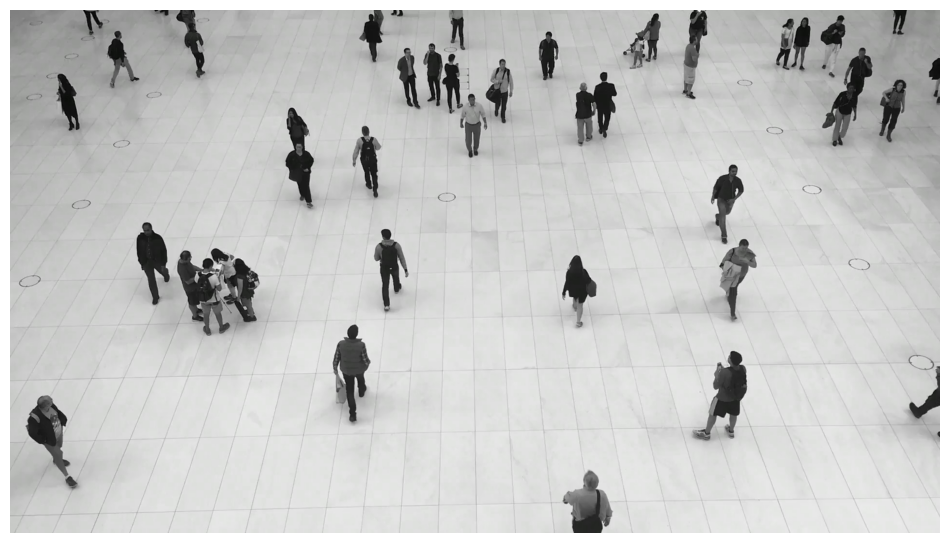

In [5]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

## Initialize ByteTrack

Initialize the [ByteTrack](https://supervision.roboflow.com/latest/trackers/#bytetrack) object.

In [6]:
byte_track = sv.ByteTrack(minimum_consecutive_frames=3)
byte_track.reset()

## Initialize CSVSink and open sink

To save detections to a .CSV file, open our [`sv.CSVSink`](https://supervision.roboflow.com/latest/how_to/save_detections/#save-detections-as-csv) and then pass the [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/#detections) object resulting from the inference to it. Its fields are parsed and saved on disk.

In [7]:
csv_sink = sv.CSVSink(FILE_NAME)
csv_sink.open()

## Process video and save detections to csv file

All the operations we plan to perform for each frame of our video - detection, tracking, annotation, and write to csv are encapsulated in a function named `callback`.

In [8]:
def callback(predictions: dict, frame: VideoFrame) -> np.ndarray:
    detections = sv.Detections.from_inference(predictions)
    detections = detections[detections.class_id == 0]
    detections = byte_track.update_with_detections(detections)
    csv_sink.append(detections, custom_data={'frame_number': frame.frame_id})

## Initilize InferencePipeline

The [`InferencePipeline`](https://inference.roboflow.com/using_inference/inference_pipeline/) interface is made for streaming and is likely the best route to go for real time use cases. It is an asynchronous interface that can consume many different video sources including local devices (like webcams), RTSP video streams, video files, etc. With this interface, you define the source of a video stream and sinks.

In [ ]:
pipeline = InferencePipeline.init(
    model_id=INFERENCE_MODEL,
    video_reference=SOURCE_VIDEO_PATH,
    on_prediction=callback,
    iou_threshold=IOU_THRESHOLD,
    confidence=CONFIDENCE_THRESHOLD,
)

In [10]:
pipeline.start()
pipeline.join()

In [11]:
csv_sink.close()

## Visualizate results of detections csv data with Pandas

Let's take a look at our resulting data with by using Pandas.

It will also be created in your current directory with the name detections.csv as well.

In [12]:
df = pd.read_csv(FILE_NAME)
df # show data

,x_min,y_min,x_max,y_max,class_id,confidence,tracker_id,class_name,frame_number
0,1138.0,932.0,1244.0,1079.0,0,0.814987,4,person,4
1,1470.0,481.0,1549.0,648.0,0,0.802217,1,person,4
2,1453.0,324.0,1524.0,486.0,0,0.794803,2,person,4
3,672.0,630.0,747.0,811.0,0,0.770701,5,person,4
4,1404.0,705.0,1516.0,888.0,0,0.699411,13,person,4
...,...,...,...,...,...,...,...,...,...
8846,77.0,700.0,169.0,892.0,0,0.477815,61,person,341
8847,1054.0,50.0,1089.0,164.0,0,0.471564,66,person,341
8848,1010.0,60.0,1055.0,175.0,0,0.406130,68,person,341
8849,424.0,465.0,509.0,605.0,0,0.352846,69,person,341


## Convert CSV data to sv.Detections

In [13]:
def csv_to_detections(csv_file: str) -> sv.Detections:
    xyxy = []
    class_id = []
    confidence = []
    tracker_id = []
    frame_number = []
    class_name = []

    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
          xyxy.append([float(row["x_min"]), float(row["y_min"]), float(row["x_max"]), float(row["y_max"])])
          class_id.append(int(row["class_id"]))
          confidence.append(float(row["confidence"]))
          tracker_id.append(int(row["tracker_id"]))
          frame_number.append(int(row["frame_number"]))
          class_name.append(row["class_name"])

    custom_data = {"frame_number": np.array(frame_number), "class_name": np.array(class_name)}
    return sv.Detections(xyxy=np.array(xyxy), class_id=np.array(class_id), confidence=np.array(confidence), tracker_id=np.array(tracker_id), data=custom_data)

In [14]:
csv_detections = csv_to_detections(FILE_NAME)

In [15]:
csv_detections

Detections(xyxy=array([[1138.,  932., 1244., 1079.],
       [1470.,  481., 1549.,  648.],
       [1453.,  324., 1524.,  486.],
       ...,
       [1010.,   60., 1055.,  175.],
       [ 424.,  465.,  509.,  605.],
       [1758.,    0., 1810.,   96.]]), mask=None, confidence=array([0.81498671, 0.80221713, 0.79480344, ..., 0.40612963, 0.35284591,
       0.30636472]), class_id=array([0, 0, 0, ..., 0, 0, 0]), tracker_id=array([ 4,  1,  2, ..., 68, 69, 57]), data={'frame_number': array([  4,   4,   4, ..., 341, 341, 341]), 'class_name': array(['person', 'person', 'person', ..., 'person', 'person', 'person'],
      dtype='<U6')})

### Annotate First Frame

Visualize the first frame of a video alongside the initial detections obtained by parsing CSV data into [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/#detections) objects. The annotated image will show the original video frame, marked with the first bounding box detected from the parsed data, providing a visual representation of the identified object(s) in the scene.

### First sv.Detections data

In [16]:
first_frame_detections = csv_detections[csv_detections.data.get("frame_number") == 4] # first detected frame number is 4

### First frame from video (Before Annotate)

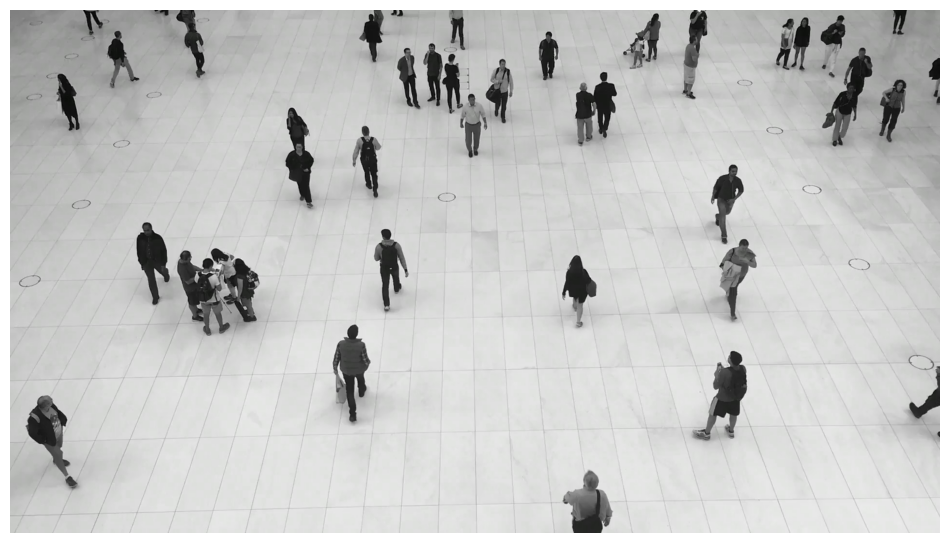

In [17]:
sv.plot_image(frame, (12, 12))

### Annotate Image with Detections

Finally, we can annotate the image with the predictions. Since we are working with an object detection model, we will use the [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.LabelAnnotator) classes.

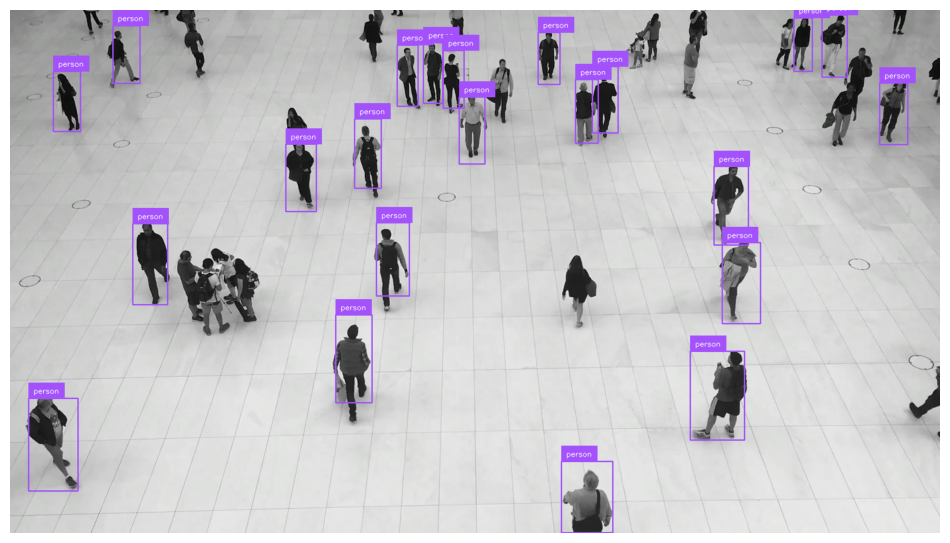

In [18]:
bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.CLASS)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.CLASS)

annotated_image = bounding_box_annotator.annotate(
    scene=frame, detections=first_frame_detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=first_frame_detections)
sv.plot_image(annotated_image, (12, 12))

## References 📚

* Supervision: https://supervision.roboflow.com
* https://supervision.roboflow.com/develop/detection/core/#detections
* Save Detections to CSV: https://supervision.roboflow.com/develop/how_to/save_detections/#save-detections-as-csv
* CSV Custom fields: https://supervision.roboflow.com/develop/how_to/save_detections/#custom-fields
* Inference: https://inference.roboflow.com/
* Inference Pipeline: https://inference.roboflow.com/using_inference/inference_pipeline/
* Inference Aliases: https://inference.roboflow.com/quickstart/aliases/

